# Primer set


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

ModuleNotFoundError: No module named 'fitter'

In [ ]:
# Abrimos y ajustamos los datos para leerlos
datos_pacientes = pd.read_csv("Datos.csv",sep = ";")
datos_pacientes["Marca de tiempo"] = pd.to_datetime(datos_pacientes["Marca de tiempo"])
datos_operaciones = pd.read_csv("Datos operaciones origen urgencias.csv")

datos_operaciones = datos_operaciones.iloc[:,:5]
datos_operaciones = datos_operaciones.drop(datos_operaciones.columns[3],axis = 1)

In [ ]:
#Estas son las áreas que aparecen en el diagrama entregado
areas_mapa_profe = ["URG101_003","DIV101_603","DIV101_604","DIV101_703","DIV102_203","DIV103_107","DIV103_204",
"DIV104_602","OPR101_011","OPR101_033","OPR102_001","OPR102_003","End"]

In [ ]:
# Lo primero que haremos será filtrar los datos para obtener el nodo "Outisde"
filtro_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))
datos_pacientes.loc[filtro_fuera,"Area"] = "Outside"

In [ ]:
#Eliminamos las filas donde el valor actual y el anterior corresponden al nodo outside, dejamos el primero,
#marcando así la entrada del paciente al nodo outside, pero solo una vez 
filtro_doble_fuera = (~datos_pacientes["Area"].isin(areas_mapa_profe))&((~datos_pacientes["Area"].shift(1).isin(areas_mapa_profe)))
datos_pacientes = datos_pacientes[~filtro_doble_fuera]


In [ ]:
datos_pacientes["Hora derivacion"] = datos_pacientes["Marca de tiempo"].shift(-1)
datos_pacientes["Estadia"] = datos_pacientes["Hora derivacion"]  - datos_pacientes["Marca de tiempo"]
datos_pacientes["Estadia"] = datos_pacientes["Estadia"]/np.timedelta64(1,"h")
datos_pacientes["Siguiente Área"] = datos_pacientes["Area"].shift(-1)

In [ ]:
import pylab as pl

In [ ]:
plt.style.use('ggplot')

Probabilidad de transición desde la sala de urgencias (DIV101_703)
Outside       34.680135
End           23.456790
DIV103_204    11.111111
DIV104_602     7.182941
DIV101_604     6.060606
DIV101_603     5.162738
DIV103_107     5.050505
DIV102_203     4.040404
OPR102_003     3.030303
OPR102_001     0.112233
OPR101_033     0.112233
Name: Siguiente Área, dtype: float64


Text(0.5, 0, 'Horas')

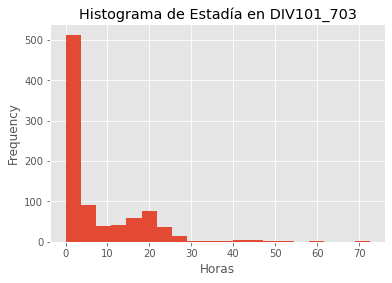

In [ ]:
area = "DIV101_703"
derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
print(f"Probabilidad de transición desde la sala de urgencias ({area})")
transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
print(transiciones)
estadia_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
hist = estadia_urgencia.plot.hist(title = f"Histograma de Estadía en {area}",bins = 20)
hist.set_xlabel("Horas")

# Analizamos caso a a caso

In [10]:
set_pacientes = set(datos_pacientes["Case ID"])
entrada = "URG101_003"
salida = "End"
dic_info_pacientes = dict.fromkeys(set_pacientes,{})
for paciente in set_pacientes:
    info_paciente = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    hora_entrada = info_paciente.iloc[0]["Marca de tiempo"]
    hora_salida = info_paciente.iloc[-1]["Marca de tiempo"]
    dic_paciente ={"Entrada":hora_entrada,"Salida":hora_salida}
    duracion = hora_salida - hora_entrada
    dic_paciente["Duracion"] = duracion/np.timedelta64(1,"h")
    procedimiento = list(info_paciente["Area"])
    ruta = "".join(procedimiento)
    dic_paciente["Ruta"] = ruta
    dic_info_pacientes[paciente] = dic_paciente
    

NameError: name 'datos_pacientes' is not defined

In [9]:
df_info_pacientes = pd.DataFrame(dic_info_pacientes).T


NameError: name 'dic_info_pacientes' is not defined

# Obtenemos el estado actual de los KPI

### Lead time promedio

In [ ]:
df_info_pacientes["Duracion"].mean()

81.9152056901192

### 5% de peores casos

In [ ]:
duraciones = df_info_pacientes["Duracion"].sort_values()
n_5_peor = int(duraciones.shape[0]*0.05)
pct_5_peores_casos = duraciones.iloc[-n_5_peor:]
print(pct_5_peores_casos.mean())
print(pct_5_peores_casos.min())
print(pct_5_peores_casos.max())

971.1093023255813
453.93333333333334
4517.7


# Analizamos las llegadas

### Histograma de llegadas(solo para llegadas en menos de 24 horas)

Text(0.5, 1.0, 'Tiempo entre llegadas (Para tiempos menores a 24 horas)')

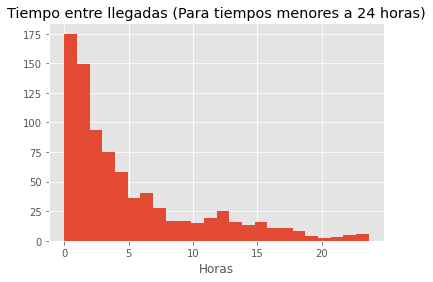

In [ ]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
hist = tiempo_entre_llegadas[tiempo_entre_llegadas < 24].hist(bins = 24)
hist.set_xlabel("Horas")
hist.set_title("Tiempo entre llegadas (Para tiempos menores a 24 horas)")

Text(0.5, 0, 'Hora del día')

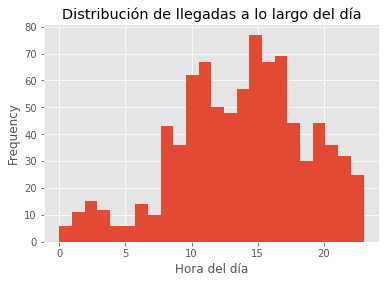

In [ ]:
horas_entrada = [entrada.hour for entrada in df_info_pacientes["Entrada"]]
df_info_pacientes["Hora entrada"] = horas_entrada
hist = df_info_pacientes["Hora entrada"].plot.hist(bins = 24,title = "Distribución de llegadas a lo largo del día")
hist.set_xlabel("Hora del día")

# Segundo set  (Operaciones)

In [ ]:
print(datos_operaciones["DURACION (hrs)"].mean())
print(datos_operaciones["DURACION (hrs)"].max())
print(datos_operaciones["DURACION (hrs)"].min())

2.4310679611650485
4.1
0.0


Text(0.5, 0, 'Horas')

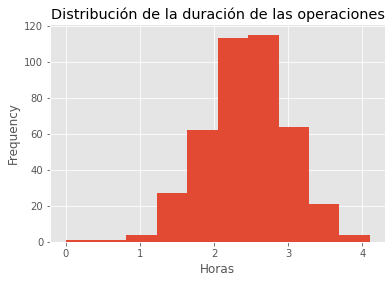

In [ ]:
hist = datos_operaciones["DURACION (hrs)"].plot.hist()
hist.set_title("Distribución de la duración de las operaciones")
hist.set_xlabel("Horas")

Text(0.5, 1.0, 'Cantidad de operaciones recibidas por paciente')

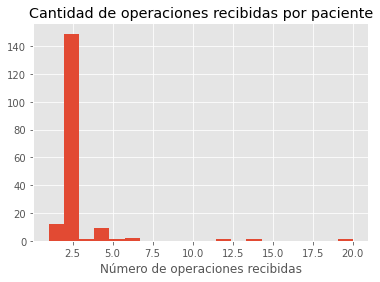

In [ ]:
hist = datos_operaciones["ID"].value_counts().hist(bins = 20)
hist.set_xlabel("Número de operaciones recibidas")
hist.set_title("Cantidad de operaciones recibidas por paciente")

Text(0, 0.5, 'Número de operaciones realizadas')

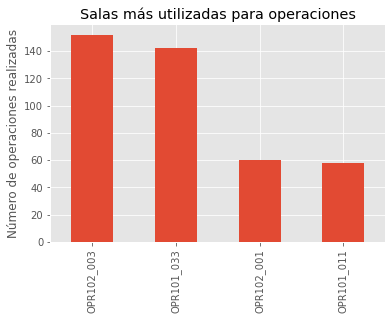

In [ ]:
barplot = datos_operaciones["SALA OPERACIONES"].value_counts().plot.bar()
barplot.set_title("Salas más utilizadas para operaciones")
barplot.set_ylabel("Número de operaciones realizadas")

In [ ]:
datos_operaciones

,ID,SALA OPERACIONES,FECHA E INICIO,DURACION (hrs)
0,14548704,OPR101_011,2018-01-02 10:15:00.000,2.8
1,14557024,OPR101_011,2017-12-22 13:37:00.000,1.6
2,14557024,OPR101_011,2018-01-12 15:36:00.000,1.2
3,14562339,OPR101_011,2018-01-03 15:56:00.000,1.3
4,14568735,OPR101_011,2018-01-05 18:34:00.000,3.2
...,...,...,...,...
407,14775043000,OPR102_003,2018-03-15 15:17:00.000,2.4
408,14799531000,OPR102_003,2018-03-26 13:02:00.000,3.3
409,14867095000,OPR102_003,2018-04-17 18:25:00.000,3.4
410,14973437000,OPR102_003,2018-05-30 13:42:00.000,2.4


In [ ]:
areas_mapa_profe

['URG101_003',
 'DIV101_603',
 'DIV101_604',
 'DIV101_703',
 'DIV102_203',
 'DIV103_107',
 'DIV103_204',
 'DIV104_602',
 'OPR101_011',
 'OPR101_033',
 'OPR102_001',
 'OPR102_003',
 'End']

# Encontramos las distribuciones 

In [ ]:
dic_distribuciones = dict.fromkeys(areas_mapa_profe)
for area in areas_mapa_profe:
    try : 
        estadia = datos_pacientes[datos_pacientes["Area"] == area]["Estadia"]
        estadia = np.array(estadia)
        f = Fitter(estadia,distributions = ["expon","beta","lognorm","norm",])
        f.fit()
        best = f.get_best(method = "sumsquare_error")
        dic_distribuciones[area] = best
        print(area,"lista")
    except:
        continue

URG101_003 lista
DIV101_603 lista
DIV101_604 lista
DIV101_703 lista
DIV102_203 lista
DIV103_107 lista
DIV103_204 lista
DIV104_602 lista
OPR101_011 lista
OPR101_033 lista
OPR102_001 lista


OPR102_003 lista


In [ ]:
dic_distribuciones

{'URG101_003': {'beta': {'a': 0.9963865319265526,
   'b': 7.549140779895584,
   'loc': -5.8548793004373246e-30,
   'scale': 22.24393218386804}},
 'DIV101_603': {'beta': {'a': 0.3616704354973971,
   'b': 165.16296501053603,
   'loc': -7.412371308927781e-26,
   'scale': 6922.807468149733}},
 'DIV101_604': {'beta': {'a': 0.45703588480386004,
   'b': 648.4486740488123,
   'loc': -8.513612931753873e-29,
   'scale': 35054.048864844575}},
 'DIV101_703': {'beta': {'a': 0.5703786223184792,
   'b': 110.83109431271232,
   'loc': -1.462673655225481e-28,
   'scale': 437.32033985936954}},
 'DIV102_203': {'beta': {'a': 0.24377071043553353,
   'b': 285.52176298361917,
   'loc': -1.187635564202615e-26,
   'scale': 5018.705281761797}},
 'DIV103_107': {'beta': {'a': 0.39836402842306595,
   'b': 206.40113822847783,
   'loc': -1.5712666431312037e-28,
   'scale': 10158.914732260619}},
 'DIV103_204': {'beta': {'a': 0.4888117957179907,
   'b': 109.8607935613231,
   'loc': -1.5936649681747108e-28,
   'scale': 

In [ ]:
dic_histogramas= {}

In [ ]:
llegadas = df_info_pacientes["Entrada"].sort_values()
tiempo_entre_llegadas = (llegadas.shift(-1) - llegadas)/np.timedelta64(1,"h")
duracion_operaciones = tiempo_entre_llegadas[tiempo_entre_llegadas < 24]
duracion_operaciones = np.array(duracion_operaciones)
f = Fitter(duracion_operaciones,distributions = ["norm","beta","lognorm","chi2"])
f.fit()
a = f.get_best(method = "sumsquare_error")
print(a)
f.summary()
f.fitter_param["lognorm"]


NameError: name 'df_info_pacientes' is not defined

In [ ]:
dic_histogramas["Tiempo_entre_llegadas"] = a

# Heatmap

In [ ]:
df_heatmap = pd.DataFrame(index = areas_mapa_profe,columns = areas_mapa_profe)

In [ ]:
areas_mapa_profe.append("Outside")

In [ ]:
for area in areas_mapa_profe:
    derivacion_urgencia = datos_pacientes[datos_pacientes["Area"] == area]["Siguiente Área"]
    transiciones = (derivacion_urgencia.value_counts()/derivacion_urgencia.shape[0])*100
    df_heatmap[area] = transiciones

In [ ]:
df_heatmap.fillna(0)

,URG101_003,DIV101_603,DIV101_604,DIV101_703,DIV102_203,DIV103_107,DIV103_204,DIV104_602,OPR101_011,OPR101_033,OPR102_001,OPR102_003,End,Outside
URG101_003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510204,0.826446,1.724138,2.112676,0.000000,0.657895,99.88466,0.000000
DIV101_603,0.000000,0.000000,0.000000,5.162738,1.408451,1.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.654867
DIV101_604,0.000000,0.000000,0.000000,6.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.433628
DIV101_703,99.084668,0.000000,0.000000,0.000000,0.000000,0.000000,1.020408,0.826446,1.724138,12.676056,0.000000,1.315789,0.00000,0.221239
DIV102_203,0.114416,1.666667,0.000000,4.040404,0.000000,0.000000,0.000000,0.000000,48.275862,0.000000,1.666667,0.000000,0.00000,0.884956
DIV103_107,0.000000,1.666667,0.000000,5.050505,0.000000,0.000000,0.000000,0.000000,5.172414,0.000000,1.666667,0.000000,0.00000,0.442478
DIV103_204,0.000000,0.000000,0.000000,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,48.591549,0.000000,9.868421,0.00000,2.876106
DIV104_602,0.114416,0.000000,0.000000,7.182941,0.000000,0.000000,12.755102,0.000000,1.724138,7.746479,0.000000,1.973684,0.00000,3.539823
OPR101_011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.826446,0.000000,0.000000,95.000000,0.000000,0.00000,0.000000
OPR101_033,0.000000,0.000000,0.000000,0.112233,0.000000,0.000000,4.591837,0.000000,0.000000,0.000000,0.000000,82.894737,0.00000,1.327434


<AxesSubplot:>

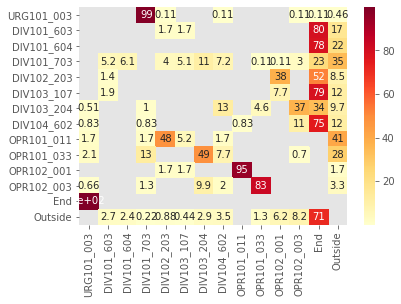

In [ ]:
import seaborn as sns
sns.heatmap(df_heatmap.T,annot = True,cmap = "YlOrRd")

# Pacientes por día

In [ ]:
salas_div  = areas_mapa_profe[:-5]


In [ ]:
estadias_div = []
for paciente in set_pacientes :
    info_pacientes = datos_pacientes[datos_pacientes["Case ID"] == paciente]
    info_hospitalizacion = info_pacientes[info_pacientes["Area"].isin(salas_div)]
    estadia = np.sum(info_pacientes["Estadia"])
    estadias_div.append(estadia)
estadia_serie = pd.Series(estadias_div)
estadia_serie = estadia_serie[(estadia_serie >0)]
print("Media de estadia en div (suma)",estadia_serie.mean())

Media de estadia en div (suma) 17.177357142857144


In [ ]:
import datetime

In [ ]:
def convertir_fecha(date):
    fecha = datetime.datetime.strftime(date,"%Y-%m-%d")
    return fecha

In [ ]:
df_info_pacientes["Fecha_entrada"] = [convertir_fecha(df_info_pacientes["Entrada"].iloc[i]) for i in range(df_info_pacientes["Entrada"].shape[0])]

df_info_pacientes

,Entrada,Salida,Duracion,Ruta,Hora entrada,Fecha_entrada
14817280,2018-03-30 18:14:00,2018-03-30 22:06:00,3.86667,URG101_003DIV101_703DIV103_204End,18,2018-03-30
14931970,2018-05-13 16:37:00,2018-05-14 00:14:00,7.61667,URG101_003DIV101_703DIV102_203OPR102_001OPR101...,16,2018-05-13
14888963,2018-04-25 16:06:00,2018-04-26 12:26:00,20.3333,URG101_003DIV101_703OutsideEnd,16,2018-04-25
14696460,2018-02-15 12:04:00,2018-02-16 15:55:00,27.85,URG101_003DIV101_703DIV101_604End,12,2018-02-15
14579725,2018-01-04 21:05:00,2018-01-04 22:46:00,1.68333,URG101_003DIV101_703End,21,2018-01-04
...,...,...,...,...,...,...
14888950,2018-04-25 17:31:00,2018-05-15 14:18:00,476.783,URG101_003DIV101_703OutsideDIV101_603End,17,2018-04-25
14682104,2018-02-08 14:27:00,2018-02-09 13:53:00,23.4333,URG101_003DIV101_703DIV104_602End,14,2018-02-08
14716923,2018-02-23 10:13:00,2018-02-23 18:39:00,8.43333,URG101_003DIV101_703End,10,2018-02-23
14716925,2018-02-23 17:47:00,2018-02-24 14:22:00,20.5833,URG101_003DIV101_703OutsideEnd,17,2018-02-23


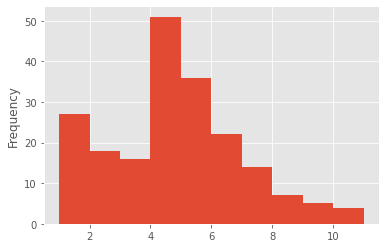

In [ ]:
hist = df_info_pacientes["Fecha_entrada"].value_counts().plot.hist()


In [ ]:
datos_atencion_urg = pd.read_csv("Datos_atencion_urg.csv")
ids_atencion = datos_atencion_urg["ID"]
set_atencion_urg = set(ids_atencion)
for paciente in set_pacientes:
    if paciente not in set_atencion_urg:
        print("Match")

Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Match
Matc

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

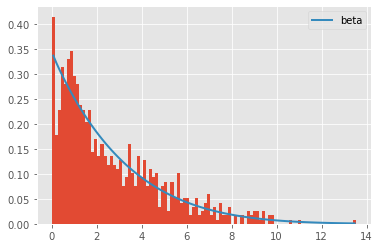

In [ ]:
estadia = datos_pacientes[datos_pacientes["Area"] == "URG101_003"]["Estadia"]
estadia = np.array(estadia)
f = Fitter(estadia,distributions = ["beta"])
f.fit()
hist = f.summary()
plt.set_title("Estadia en URG101_003 distribución ajustada")
plt.set_xlabel("Horas")

In [ ]:
help(Fitter.summary)

Help on function summary in module fitter.fitter:

summary(self, Nbest=5, lw=2, plot=True, method='sumsquare_error', clf=True)
    Plots the distribution of the data and Nbest distribution

